In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import hopsworks
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

In [2]:
wine_df = pd.read_csv("data/wine.csv")

In [3]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


**From this we can gather two important issues that need to be handled**
1. The feature `type` is of type object and needs to be handled differently  
than the other features  
2. There are a couple of nan values for some of the feature categories these  
 need to be handled in som type of way.



Lets handle the first issue by introducing a dummy variable i.e. introduce  
one feature that is type-white and another that is type-red and let them be  
0 or 1. This is often called one-hot encoding.

In [4]:
dummy_variables_type = pd.get_dummies(wine_df.type,prefix='type',dtype='int')
dummy_variables_type

,type_red,type_white
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
6492,1,0
6493,1,0
6494,1,0
6495,1,0


In [5]:
wine_df = pd.concat([dummy_variables_type,wine_df],axis=1)
wine_df = wine_df.drop('type',axis=1)

Lets now deal with the features where we have nan values

In [6]:
for col in wine_df.columns:
    
    n_null_values = wine_df[col].isnull().sum()
    
    if n_null_values > 0:
        print(col, n_null_values)

fixed acidity 10
volatile acidity 8
citric acid 3
residual sugar 2
chlorides 2
pH 9
sulphates 4


Since there are only a few nan values over the entire dataset it is sufficient to  
just replace those nan values with the average value for the same feature and quality.

In [7]:
mean_feature_value_per_qualityGroup = wine_df.groupby('quality').mean()
mean_feature_value_per_qualityGroup

,type_red,type_white,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,,,,,,,,,,,,,
3,0.333333,0.666667,7.853333,0.517000,0.281000,5.140000,0.077033,39.216667,122.033333,0.995744,3.257667,0.506333,10.215000
4,0.245370,0.754630,7.288889,0.457963,0.272315,4.153704,0.060158,20.636574,103.432870,0.994833,3.231620,0.504884,10.180093
5,0.318522,0.681478,7.329348,0.389768,0.307721,5.804116,0.064666,30.237371,120.839102,0.995849,3.212042,0.526416,9.837783
6,0.224965,0.775035,7.178037,0.313731,0.323786,5.551182,0.054168,31.165021,115.410790,0.994558,3.217701,0.532466,10.587553
7,0.184430,0.815570,7.128962,0.288895,0.334764,4.733952,0.045272,30.422150,108.498610,0.993126,3.227790,0.547025,11.386006
8,0.093264,0.906736,6.838542,0.291010,0.332539,5.382902,0.041124,34.533679,117.518135,0.992514,3.223212,0.512487,11.678756
9,0.000000,1.000000,7.420000,0.298000,0.386000,4.120000,0.027400,33.400000,116.000000,0.991460,3.308000,0.466000,12.180000


In [8]:
for col in wine_df.columns:

    nan_indexes = wine_df[wine_df[col].isnull()]

    for index, row in nan_indexes.iterrows():

        quality = row.quality
        mean_value = mean_feature_value_per_qualityGroup.at[quality, col]

        wine_df.at[index, col] = mean_value

In [9]:
wine_df.isna().sum()

type_red                0
type_white              0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Now there are no more nan values.

Lets also check for duplicates and remove them if they do exist. 

In [10]:
wine_df.duplicated().sum()

1168

In [11]:
wine_df.duplicated().sum()/len(wine_df)

0.1797752808988764

We apparantly have quite a substantial number of duplicates almost 18 %, lets remove them

In [12]:
wine_df = wine_df.drop_duplicates()

In [13]:
wine_df.duplicated().sum()

0

We have now dropped 1168 out of 6497 values but at least we have no more duplicates.
We can now consider the data cleaned enough for an EDA 

Lets take a quick look at some of the simple statistics of the dataset.

In [14]:
wine_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
type_red,5329.0,0.255020,0.435913,0.00000,0.0000,0.00000,1.00000,1.00000
type_white,5329.0,0.744980,0.435913,0.00000,0.0000,1.00000,1.00000,1.00000
fixed acidity,5329.0,7.216579,1.317970,3.80000,6.4000,7.00000,7.70000,15.90000
volatile acidity,5329.0,0.344097,0.168110,0.08000,0.2300,0.30000,0.41000,1.58000
citric acid,5329.0,0.318738,0.147075,0.00000,0.2400,0.31000,0.40000,1.66000
residual sugar,5329.0,5.053872,4.503167,0.60000,1.8000,2.70000,7.50000,65.80000
chlorides,5329.0,0.056668,0.036838,0.00900,0.0380,0.04700,0.06600,0.61100
free sulfur dioxide,5329.0,30.060143,17.815588,1.00000,16.0000,28.00000,41.00000,289.00000
total sulfur dioxide,5329.0,114.189341,56.781422,6.00000,75.0000,116.00000,154.00000,440.00000
density,5329.0,0.994536,0.002966,0.98711,0.9922,0.99464,0.99677,1.03898


### Exploratory Data Analysis (EDA) on the wine data

Let's look at our wines - the distribution and range of values for the 13 different features
 * type_red
 * type_white
 * fixed acidity
 * volatile acidity
 * citric acid
 * residual sugar
 * chlorides
 * free sulfur dioxide
 * total sulfur dioxide
 * density
 * pH
 * sulphates
 * alcohol
 
 and the target variable is `quality`.

#### First lets have a look at the target variable

<Axes: xlabel='quality', ylabel='Count'>

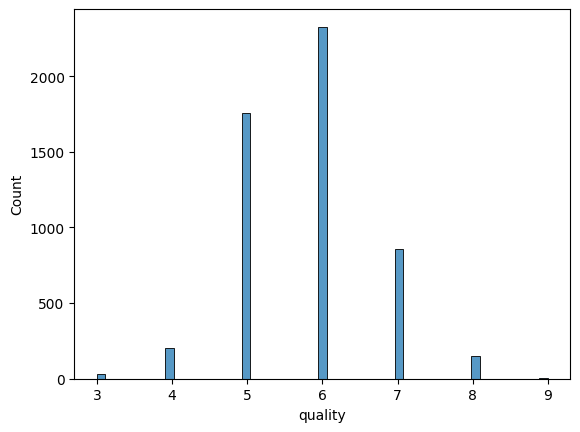

In [15]:
sns.histplot(wine_df, x='quality')

We can tell that there are very few values in the categories 3 and 9.  

We can also tell that the majority of the values are in classes 5 or 6.  

It is important to keep this uneven distribution in mind for when we  
decide to create a model. A naive classifier that always responds 6  
would do "ok" on this dataset, however would probably be horrible   
in comparison to real world data. 

##### Then lets have a look at the correlation matrix

<Axes: >

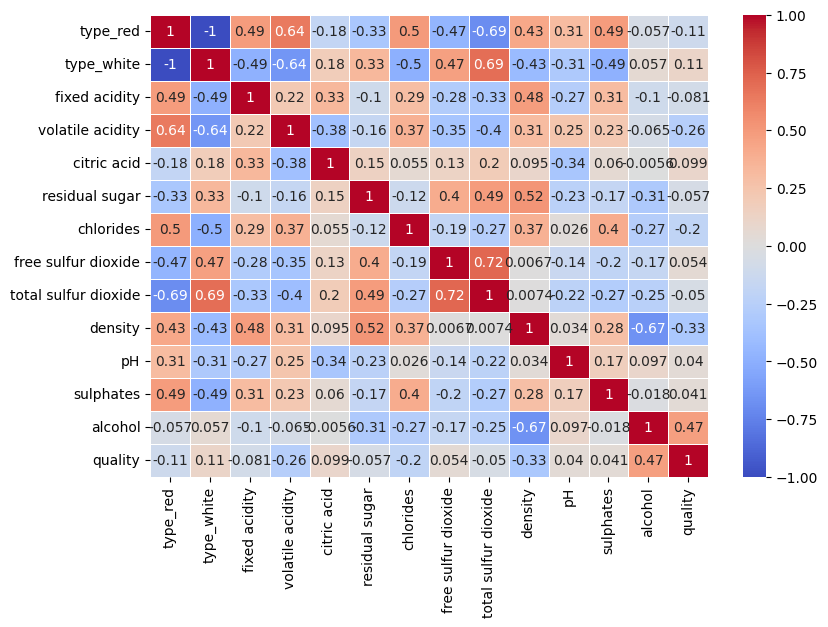

In [16]:
plt.figure(figsize=(9,6))
sns.heatmap(wine_df.corr(),annot=True,linewidths=0.5,cmap='coolwarm')

The first and most important conclusion from this correlation matrix is that  
there is a 1:1 correlation between type_white and type_red, this is to be expected  
but since there are only two types of wine, it makes sense to remove type_red to  
avoid colinearity.

#### Removing further colinearity
We can use variance inflation factor to further explore the colinearity of our data  
a high value of *VIF* leads signifies that the "independent" variables are highly 
related and this can in turn lead to worse prediction power in the models.

In [19]:
wdf2 = wine_df.copy()
wdf2 = wdf2.drop('quality',axis=1)
# wdf2 = wdf2[['total sulfur dioxide','free sulfur dioxide']]#.drop('free sulfur dioxide',axis=1)
wdf2 = wdf2.drop('type_red',axis=1)
wdf2 = wdf2.drop('density',axis=1)
wdf2 = wdf2.drop('pH',axis=1)

In [20]:
vif_data = pd.DataFrame() 
vif_data["feature"] = wdf2.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(wdf2.values, i) for i in range(len(wdf2.columns))]

vif_data.sort_values('VIF',ascending=False)

,feature,VIF
9,alcohol,52.480695
1,fixed acidity,38.830407
7,total sulfur dioxide,19.475264
8,sulphates,18.894374
0,type_white,15.460830
2,volatile acidity,10.246491
3,citric acid,9.144721
6,free sulfur dioxide,8.435796
5,chlorides,5.010686
4,residual sugar,3.144345


In [21]:
# plt.figure(figsize=(9,6))
# sns.heatmap(wine_df.drop(['quality'],axis=1).corr(),annot=True,linewidths=0.5,cmap='coolwarm')

In [22]:
# plt.figure(figsize=(9,6))
# sns.heatmap(wdf2.corr(),annot=True,linewidths=0.5,cmap='coolwarm')

### Conclusions from looking at the colinearity
After looking at the *VIF* values of this dataset, the conclusion is  
that the dataset is very very colinear. It makes sense given that many  
of the categories are related.

Take `fixed acidity`, `volatile acidity`, `citric acid` and `pH`  
for example they are all related to acidity, and we can expect that if the  
`fixed acidity` goes up then the `pH` value will go down.

It goes somewhat beyond the scope of this assignment to further break  
down this analysis, but I think spending time on this in particular can be  
very helpful for model generation in the future.

The conclusions on a level that is reasonable to this report is that `pH`  
is highly colinear and `density` as well. These two features could be  
removed, lets look at the rest of the EDA first.

Next step is to look into the correlations with the target value specifically

/var/folders/ww/8ttgz8d96p7_x_9ydfjr3_nm0000gn/T/ipykernel_64540/3937348258.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(),rotation=45)


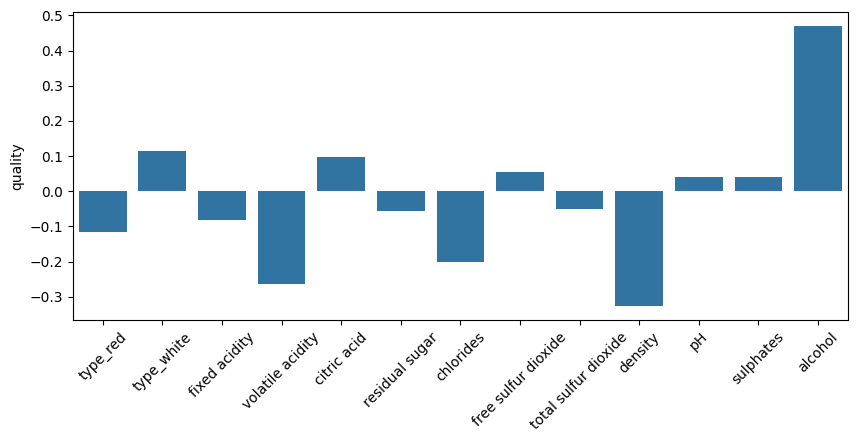

In [23]:
plt.figure(figsize=(10,4))

# We drop quality on the row axis and then uses the correlations on the column axis
correlation_matrix = wine_df.corr().drop('quality')['quality']
g = sns.barplot(correlation_matrix)

# Rotate the coloumn names so that we can see them in the plot.
g.set_xticklabels(g.get_xticklabels(),rotation=45)
plt.show()

#### Correlation "significance"

In [24]:
feature_cols = wine_df.drop('quality',axis=1).columns

corrs_and_pvalues = [scipy.stats.pearsonr(wine_df['quality'],wine_df[feature_col]) for feature_col in feature_cols]
corrs, pvalues = zip(*corrs_and_pvalues)

significance_df = pd.DataFrame()
significance_df['feature'] = feature_cols
significance_df['correlation with quality'] = corrs
significance_df['p value of correlation'] = pvalues
significance_df.sort_values('p value of correlation')

,feature,correlation with quality,p value of correlation
12,alcohol,0.469555,1.760559e-290
9,density,-0.326978,5.332813e-133
3,volatile acidity,-0.264483,5.374485e-86
6,chlorides,-0.202357,2.327822e-50
0,type_red,-0.114889,4.003973e-17
1,type_white,0.114889,4.003973e-17
4,citric acid,0.098780,4.941575e-13
2,fixed acidity,-0.080766,3.543966e-09
5,residual sugar,-0.057293,2.853837e-05
7,free sulfur dioxide,0.054456,6.969548e-05


In [25]:
significance_df['p > 0.05'] = [p > 0.05 for p in pvalues]
significance_df['p > 0.01'] = [p > 0.01 for p in pvalues]
significance_df['p > 0.001'] = [p > 0.001 for p in pvalues]
significance_df[significance_df['p > 0.05']]

,feature,correlation with quality,p value of correlation,p > 0.05,p > 0.01,p > 0.001


In [26]:
significance_df[significance_df['p > 0.01']]

,feature,correlation with quality,p value of correlation,p > 0.05,p > 0.01,p > 0.001


In [27]:
significance_df[significance_df['p > 0.001']]

,feature,correlation with quality,p value of correlation,p > 0.05,p > 0.01,p > 0.001
10,pH,0.039996,0.003498,False,False,True
11,sulphates,0.041469,0.002463,False,False,True


#### Based on the above we can notice the following
The features `sulphates` and `ph` have a low correlation with quality and  
this correlation is not considered significant at the 99,9 % confidence level.  
They could be removed, especially `pH` that was shown to be highly colinear  
as well

Here we can pairplot them as well, however, it seems quite unneccessary since it is  
difficult to keep track of what happens.  

If there are any interesting relationships we want to look closer at, we can slice the  
dataframe and chose to keep only the relevant features


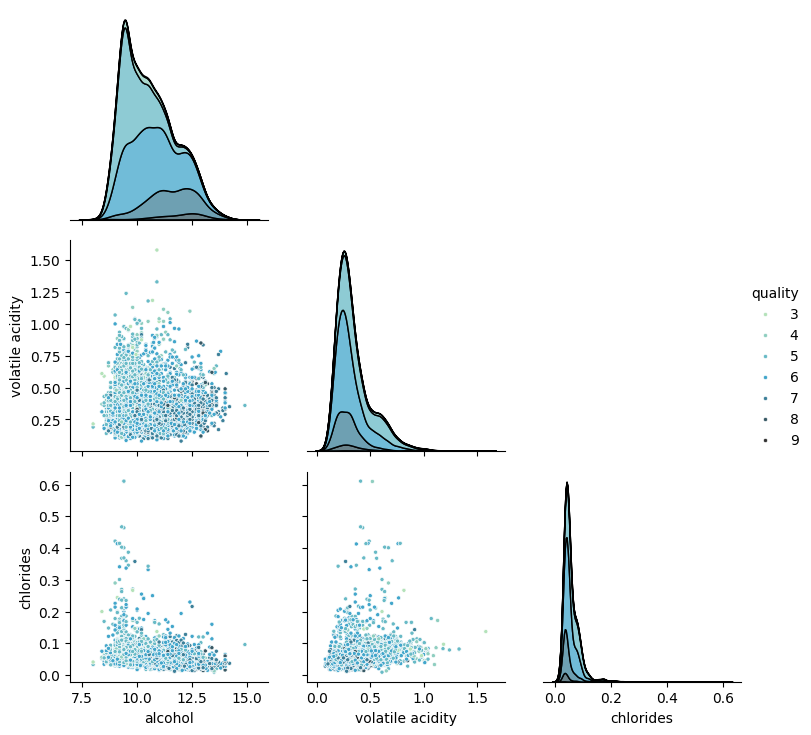

In [28]:
features_to_look_into = ['alcohol','volatile acidity','chlorides'] + ['quality']

# g = sns.PairGrid(wine_df, hue='quality', palette='GnBu_d',diag_sharey=False, corner=True)
g = sns.PairGrid(wine_df[features_to_look_into], hue='quality', palette='GnBu_d',diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot,marker='.')
g.map_diag(sns.kdeplot,multiple="stack")
g.add_legend()

## Conclusions on the EDA

Features to be removed: type_red

Features that could be removed: density,pH based on VIF & pH, sulphates based on pearson corr p value
Decisions on the features above:
* **Keep** *Density*, has very high VIF but atleast high correlation and low p-value
* **Remove** *pH* based on very high VIF, low correlation and high p-value
* **Remove** *sulphates* based on medium high VIF, low correlation and high p-value


Extra feature engineering and EDA should spend time on this:
* Handling the skewed target value group
* Spending time on breaking up Collinearity, by dropping or changing some features
* Investigating if data should be scaled and reweighted

In [29]:
wine_df = wine_df.drop(['type_red','pH','sulphates'],axis=1)

### Insert our Wine DataFrame into a FeatureGroup
Let's write our historical wine feature values and labels to a feature group.
When you write historical data, this process is called `backfilling`.

In [30]:
project = hopsworks.login()
fs = project.get_feature_store()

/Users/adrian/miniconda3/envs/sml-jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/193686
Connected. Call `.close()` to terminate connection gracefully.


In [39]:
# Rename columns in order to fit in with hopsworks conventions
cols_no_spaces = [col.replace(' ','_') for col in wine_df.columns]
wine_df.columns = cols_no_spaces
feature_cols_no_spaces = wine_df.drop('quality',axis=1).columns

In [40]:
wine_fg = fs.get_or_create_feature_group(
    name="wine",
    version=1,
    primary_key=feature_cols_no_spaces,
    description="Wine quality dataset")

wine_fg.insert(wine_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/193686/fs/193605/fg/229739


Uploading Dataframe: 100.00% |██████████| Rows 5329/5329 | Elapsed Time: 00:08 | Remaining Time: 00:00


Launching job: wine_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/193686/jobs/named/wine_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x2a8ffe380>, None)